<a href="https://colab.research.google.com/github/shellymduncan/Sales-Predictions/blob/main/Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shelly-Ann Duncan

## 9/16/22

## Project 1, Part 5

# Import libraries

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import set_config
set_config(display='diagram')

# Load data 

In [95]:
filename = '/content/drive/MyDrive/02 - Week 2/sales_predictions (1).csv'
df = pd.read_csv(filename)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Make a copy of the original dataframe to avoid manipulations

In [96]:
ml_df = df.copy()

# Check the datatypes 

In [97]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Check for missing data 
* Identify how much data is missing.

In [98]:
ml_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [99]:
ml_df.isna().sum().sum()

3873

# Check for duplicates
* We may not want duplicate data in our data set

In [100]:
ml_df.duplicated().sum()

0

# Checking for and fixing any inconsistencies in the categorical data

In [101]:
# Item Fat Content column
ml_df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [102]:
# Creating two categories, Low Fat and Regular
ml_df['Item_Fat_Content'].replace({'reg': 'Regular', 'LF': 'Low Fat', 'low fat': 'Low Fat'}, inplace = True)
ml_df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [103]:
# Outlet Size column
ml_df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [104]:
# Changing the category High to Large so it can be ordinal
ml_df['Outlet_Size'].replace({'High': 'Large'}, inplace = True)
ml_df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

* All inconsistencies in the categorical data are fixed.

# Summary of the statistics for the numberical columns

In [105]:
ml_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Keeping the relevant features (X) columns and target (y): Item_Outlet_Sales.

In [106]:
# Keeping relevant columns for this dataset
ml_df = ml_df[['Item_Fat_Content', 'Item_Type', 'Item_MRP', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']]
ml_df.head()


,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,Low Fat,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,Regular,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,Low Fat,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,Regular,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,Low Fat,Household,53.8614,1987,Large,Tier 3,Supermarket Type1,994.7052


# Ordinal encoding Outlet_Size and Outlet_Location_Type

In [107]:
# Ordinal encoding Outlet Size column to avoid error in data when preprocessing
replace_dict = {'Small': 0, 'Medium': 1, 'Large': 2}
ml_df['Outlet_Size'].replace(replace_dict, inplace = True)
ml_df['Outlet_Size']

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


0       1.0
1       1.0
2       1.0
3       NaN
4       2.0
       ... 
8518    2.0
8519    NaN
8520    0.0
8521    1.0
8522    0.0
Name: Outlet_Size, Length: 8523, dtype: float64

In [108]:
# Ordinal endcoding Outlet Location Type column to avoid error in data when preprocessing
ml_df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [109]:
replace_dict1 = {'Tier 1': 0, 'Tier 2': 1, 'Tier 3': 2}
ml_df['Outlet_Location_Type'].replace(replace_dict1, inplace = True)
ml_df['Outlet_Location_Type']

0       0
1       2
2       0
3       2
4       2
       ..
8518    2
8519    1
8520    1
8521    2
8522    0
Name: Outlet_Location_Type, Length: 8523, dtype: int64

In [110]:
# define X features and y target
X = ml_df.drop(columns = ['Item_Outlet_Sales'])
y = ml_df['Item_Outlet_Sales']

In [111]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Preprocessing the dataset for Machine Learning

In [112]:
# instantiate column selectors
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')

# Instantiate Transformers 

In [113]:
# Imputers 
freq_imputer = SimpleImputer(strategy = 'most_frequent')
mean_imputer = SimpleImputer(strategy = 'mean')

# Scale
scaler = StandardScaler()

# One hot encoder
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

# Instantiate Pipelines

In [114]:
# numeric pipleine for numerical data
num_pipe = make_pipeline(mean_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [115]:
# categorical pipeline for categorical data
cat_pipe = make_pipeline(freq_imputer, ohe)
cat_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Instantiate ColumnTransformer

In [116]:
# create tuples for the column transformer
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

# ColumnTransformer
processed = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')
processed

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f805d1afb50>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f805d1afb90>)])

# Transform data

In [117]:
# fit the column transfer(processed) only on the training data
processed.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f805d1afb50>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f805d1afb90>)])

In [118]:
# now we use the fitted ColumnTransformer(processed) on training and testing datasets
X_train_processed = processed.transform(X_train)
X_test_processed = processed.transform(X_test)

# Inspect results

In [119]:
# check for missing values, scaled data and one hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values \n')
print(np.isnan(X_test_processed).sum().sum(), 'missing values \n')
X_train_processed

0 missing values 

0 missing values 



array([[ 1.82810922,  1.32784893,  0.40778536, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.60336888,  1.32784893,  0.40778536, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.24454056,  0.13618724,  0.40778536, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.52302674,  0.49368575,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.38377708,  1.0895166 ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.73836105, -0.10214509, -1.29162953, ...,  1.        ,
         0.        ,  0.        ]])

# Project 1 -Final 

# 9/22/22

1. Your first task is to build a linear regression model to predict sales.
* Build a linear regression model.
* Evaluate the performance of your model based on r^2.
* Evaluate the performance of your model based on rmse.

2. Your second task is to build a regression tree model to predict sales.
* Build a simple regression tree model.
* Compare the performance of your model based on r^2.
* Compare the performance of your model based on rmse.

3. You now have tried 2 different models on your data set. You need to determine which model to implement.
* Overall, which model do you recommend?
* Justify your recommendation.

4. To finalize this project, complete a README in your GitHub repository including:
* An overview of the project
* 2 relevant insights from the data (supported with reporting quality visualizations)
* Summary of the model and its evaluation metrics
* Final recommendations 


# Creating a linear regression model to predict sales

In [120]:
# instantiate the model
reg = LinearRegression()

In [121]:
# create a modeling pipeline 
reg_pipe = make_pipeline(processed, reg)

In [122]:
# fit the model on the training data 
reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f805d1afb50>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f805d1afb90>)])),
                ('linearregression', LinearRegression())])

In [123]:
# make predictions about the data 
train_pred = reg_pipe.predict(X_train)
test_pred = reg_pipe.predict(X_test)

In [124]:
# Evaluate the performance of the model based on r^2
# calculating R2 in Python
train_r2 = np.corrcoef(y_train, train_pred)[0][1]**2
test_r2 = np.corrcoef(y_test, test_pred)[0][1]**2

print(f'Model Training R2: {train_r2}')
print(f'Model Testing R2: {test_r2}')

Model Training R2: 0.560403138430028
Model Testing R2: 0.5668304431491632


In [125]:
# Evaluate the performance of model based on rmse
# calculating rmse in Python
train_RMSE = np.sqrt(np.mean(np.abs(train_pred - y_train)**2))
test_RMSE = np.sqrt(np.mean(np.abs(test_pred - y_test)**2))

print(f'Model Training RMSE: {train_RMSE}')
print(f'Model Testing RMSE: {test_RMSE}')

Model Training RMSE: 1140.5995965566647
Model Testing RMSE: 1094.1330614463827


# Build a regression tree model to predict sales

In [126]:
# regression tree model 
# Decision tree
# create instance model
dec_tree = DecisionTreeRegressor(random_state = 42)

In [127]:
# create pipeline
dec_tree_pipe = make_pipeline(processed, dec_tree)
dec_tree_pipe
                        

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f805d1afb50>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f805d1afb90>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [128]:
# fit the model on the training data to learn about the relations ship between the features and target
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f805d1afb50>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f805d1afb90>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [129]:
# predict the target values for the train and test set
train_pred_pipe = dec_tree_pipe.predict(X_train)
test_pred_pipe = dec_tree_pipe.predict(X_test)

In [130]:
# evaluate the model performance
train_score = dec_tree_pipe.score(X_train, y_train)
test_score = dec_tree_pipe.score(X_test, y_test)
print(train_score)
print(test_score)

0.9998487583179675
0.1634315989495726


In [131]:
# tuning the model
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [132]:
# get the dept of our tree
dec_tree.get_depth()

39

In [133]:
# create a range of max_depth values to loop over
depths = range(1, 40)
# create a dataframe to store train and test scores.
scores = pd.DataFrame(columns=['Train','Test'], index=depths)
# loop over the values in the depths range 
for depth in depths:
  # fit a new model with the depth
  dec = DecisionTreeRegressor(max_depth=depth)
  # put model in a pipeline
  dec_pipe = make_pipeline(scaler, dec)
  # evaluate the model using R2 score
  train_r2 = r2_score(y_train, train_pred)
  test_r2 = r2_score(y_test, test_pred)
  # store the scores in a dataframe
  scores.loc[depth, 'Train'] = train_r2
  scores.loc[depth, 'Test'] = test_r2

In [134]:
# test predictions
test_pred

array([1331.93456086,  773.56238731,  829.5042718 , ..., 3434.39528821,
       1954.70550047, 2426.09453763])

In [135]:
# print scores
scores

,Train,Test
1,0.560403,0.566097
2,0.560403,0.566097
3,0.560403,0.566097
4,0.560403,0.566097
5,0.560403,0.566097
6,0.560403,0.566097
7,0.560403,0.566097
8,0.560403,0.566097
9,0.560403,0.566097
10,0.560403,0.566097


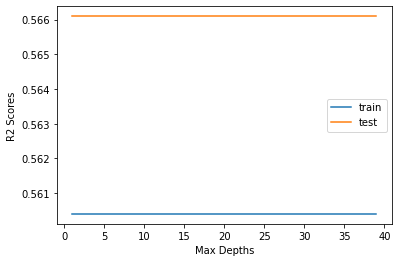

In [136]:
#plot the scores to visually determine the best max_depth
plt.plot(depths, scores['Train'], label = 'train')
plt.plot(depths, scores['Test'], label = 'test')
plt.ylabel('R2 Scores')
plt.xlabel('Max Depths')
plt.legend()
plt.show()

In [137]:
# sort the dataframe by test scores and save the index (k) of the best score
scores.sort_values(by='Test', ascending=False)

,Train,Test
1,0.560403,0.566097
30,0.560403,0.566097
23,0.560403,0.566097
24,0.560403,0.566097
25,0.560403,0.566097
26,0.560403,0.566097
27,0.560403,0.566097
28,0.560403,0.566097
29,0.560403,0.566097
31,0.560403,0.566097


In [138]:
# print the best score
best_depth = scores.sort_values(by='Test', ascending=False).index[0]
best_depth

1

# With 2 different models on the dataset, determine which model to implement.

* I would recommend the linear regression model to implement on this dataset because it gives a better representation/prediction of sales .